# A predictor for in race win and podium probability

What will be carried out in the following is the training and the testing of an in-race win and podium probability predictor with a outlook for developemnts in a tool working before the race even starts.

After some toughts for which I thank UniPD professor Alberto Testolin, Random forests will be applied to loo for a proper solution. XGBoost will be also tried out to further expand initial findings.


## The data

The data consists into a Pandas DataFrame containing intermediate ties and results of the Biathlon world cup season from 2016-2017 to 2021-2022. All the seasons but the last one, which is used for testing, are used for training.


In [1]:
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from matplotlib.patches import Rectangle

In [ ]:
data_df = pd.read_csv('../data/sixth_df_input.csv')

In [ ]:
data_df['Rank'] = data_df['Rank'].astype('int')
data_df.head()

,full_name,distance,Rank,sex,Behind,format,season,date,date_order,position,...,gradient_back,gradient_standing,gradient_prone,gradient_pos,behind_above,behind_below,standing_above,standing_below,prone_above,prone_below
0,Dorothea_Wierer,1.1,30,women,0.0,individual,2016-2017,2016-11-30,1.0,1.0,...,0.0,0.0,0.0,0.0,217.035531,0.000000,13.507138,0.000000,15.798079,0.000000
1,Kaisa_Makarainen,1.1,23,women,1.0,individual,2016-2017,2016-11-30,1.0,2.0,...,0.0,0.0,0.0,0.0,209.589657,-0.950000,13.456853,0.723128,15.749754,0.835813
2,Mari_Eder,1.1,63,women,1.8,individual,2016-2017,2016-11-30,1.0,3.0,...,0.0,0.0,0.0,0.0,205.531178,-2.432000,13.449124,1.369304,15.707010,1.622503
3,Gabriela_Koukalova,1.1,16,women,3.8,individual,2016-2017,2016-11-30,1.0,4.0,...,0.0,0.0,0.0,0.0,178.639363,-7.851750,13.510702,1.923400,15.816873,2.237088
4,Lucie_Charvatova,1.1,40,women,7.9,individual,2016-2017,2016-11-30,1.0,5.0,...,0.0,0.0,0.0,0.0,110.768851,-22.301713,13.471507,2.534512,15.746402,2.972536


In [ ]:
data_df.columns

Index(['full_name', 'distance', 'Rank', 'sex', 'Behind', 'format', 'season',
       'date', 'date_order', 'position', 'km_to_go', 'standing_remaining',
       'prone_remaining', 'probability_standing', 'probability_prone',
       'all_mistakes_prone', 'all_mistakes_standing', 'back_from_median',
       'gradient_back', 'gradient_standing', 'gradient_prone', 'gradient_pos',
       'behind_above', 'behind_below', 'standing_above', 'standing_below',
       'prone_above', 'prone_below'],
      dtype='object')

In [ ]:
dict_map_sex = {'men': 1, 'women': 0}
data_df['sex'] = data_df['sex'].map(dict_map_sex)

dict_map_format = {'sprint' : 0, 'pursuit': 1, 'individual': 2, 'mass_start': 3, 'sprint_2': 0, 'pursuit_2': 1}
data_df['format'] = data_df['format'].map(dict_map_format)

def rank_transform(x):
    if x == 1:
        return 0
    elif x == 2 or x == 3:
        return 1
    elif x > 3:
        return 2

data_df['Rank'] = data_df['Rank'].apply(rank_transform)

In [ ]:
final_df = data_df[['season', 'Rank', 'distance', 'Behind', 'format', 'position', 'km_to_go', 'standing_remaining', 'prone_remaining', 'probability_standing',\
    'probability_prone', 'back_from_median', 'gradient_back', 'all_mistakes_prone', 'all_mistakes_standing', 'gradient_standing', 'gradient_prone',\
        'gradient_pos', 'behind_above', 'behind_below', 'standing_above', 'standing_below', 'prone_above', 'prone_below']]

final_df_train = final_df[final_df['season'] != '2021-2022']
final_df_test = final_df[final_df['season'] == '2021-2022']
final_df_validation = final_df[final_df['season'] == '2020-2021']
final_df_train_valid = final_df[(final_df['season'] != '2021-2022') & (final_df['season'] != '2020-2021')]



In [ ]:
final_df_train = final_df_train.drop(['season'], axis = 1)
final_df_test = final_df_test.drop(['season'], axis = 1)
final_df_validation = final_df_validation.drop(['season'], axis = 1)
final_df_train_valid = final_df_train_valid.drop(['season'], axis = 1)

In [ ]:
weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes = np.unique(final_df_train['Rank']), y = final_df_train['Rank'])

In [ ]:
weights_dict = {'0': weights[0], '1': weights[1], '2': weights[2]}
weights

array([24.42774086, 12.21387043,  0.34756148])

In [ ]:
final_df_test = final_df_test.drop(columns = ['distance'])
final_df_train = final_df_train.drop(columns = ['distance'])

In [41]:
print(final_df_train.iloc[:,1:].shape, final_df_test.iloc[:, 1:].shape)

(264699, 21) (59733, 21)


In [ ]:

RF_clf = RandomForestClassifier(max_depth=30, class_weight =  weights_dict, n_estimators=100, random_state=0, min_samples_leaf = 10)
RF_clf.fit(final_df_train.iloc[:,1:], final_df_train.iloc[:,0].astype(str))

train_err = 1 - RF_clf.score(final_df_train.iloc[:,1:], final_df_train.iloc[:,0].astype(str),\
     sample_weight = final_df_train['Rank'].astype(str).map(weights_dict))
print("Training error = %1.3f" % train_err)
test_err = 1 - RF_clf.score(final_df_test.iloc[:,1:], final_df_test.iloc[:,0].astype(str),\
     sample_weight = final_df_test['Rank'].astype(str).map(weights_dict))
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([RF_clf.feature_names_in_, RF_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

In [ ]:
final_predictions = RF_clf.predict(final_df_test.iloc[:,1:])

In [ ]:
y_true = final_df_test.iloc[:,0].astype(str).values

In [ ]:
y_diff = y_true.astype(int) - final_predictions.astype(int)

In [ ]:
print('The accuracy of the model is:', len(y_diff[y_diff == 0])/len(y_diff))

The accuracy of the model is: 0.9492073058443407


In [ ]:

cm = metrics.confusion_matrix(y_true, final_predictions, normalize = 'true')
label_names=['0' , '1', '2']

In [4]:
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',['ghostwhite', 'aliceblue', 'skyblue', 'cornflowerblue', 'royalblue', 'blue', 'navy'], N=256)

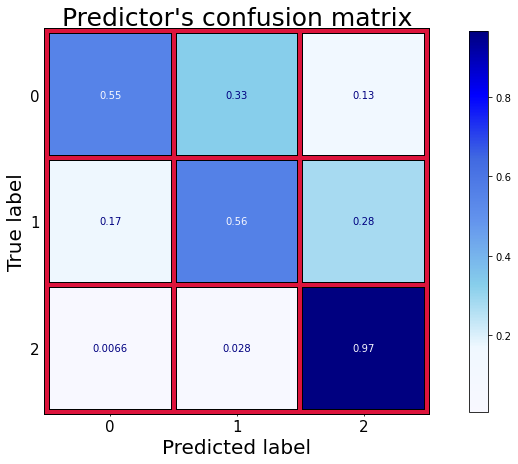

In [ ]:

fig, ax = plt.subplots(1, 1, figsize = (15, 7))

disp = metrics.ConfusionMatrixDisplay(cm, display_labels=label_names)
disp.plot(ax = ax, cmap = cmap)
ax.set_ylabel('True label', fontsize = 20)
ax.set_xlabel('Predicted label', fontsize = 20)
ax.set_xticklabels(labels =label_names, rotation = 0, fontsize = 15)
ax.set_yticklabels(labels =label_names, fontsize = 15)
ax.set_title('Predictor\'s confusion matrix', fontsize = 25)

x, y, w, h = 0, 0, 1, 1



for i in range(3):
    ax.add_patch(Rectangle((x - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))
    ax.add_patch(Rectangle((x + 1 - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))
    ax.add_patch(Rectangle((x + 2 - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))

for i in range(3):
    ax.add_patch(Rectangle((x - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))
    ax.add_patch(Rectangle((x + 1 - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))
    ax.add_patch(Rectangle((x + 2 - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, final_predictions, target_names = label_names))

              precision    recall  f1-score   support

           0       0.40      0.55      0.46       790
           1       0.32      0.56      0.41      1580
           2       0.99      0.97      0.98     57363

    accuracy                           0.95     59733
   macro avg       0.57      0.69      0.62     59733
weighted avg       0.96      0.95      0.96     59733



## Brief description of the results

We can see, excpecially from the abve confusion matrix, how thr Random forest is really working in teh right direction. The following trends are indeed encouraging:

- The model is able to predict the racers potside odium position with high accuracy:
    this is indeed what we expect because most of our dataset is composed by biathletes that are far away from the top.

<br/>

- The model is able to predict both winner and podium positions with high enough accuracy:
    in the discussion of this point just consider as a lot of times few features divide a winner from a podium racer and an athlete who finished in the top 3 versus on who arrives 4th or 5th. That is even more true if we look at early race predictions, where a lot of shooting and skiing is left to do.


## Further developments

What we do now is building on the previous results in order to fine tune the various parameters of a random forest classifier. 
We cjoose to do it using a validation set before finally re-training our final model on teh previously dìsed test set.

Later in teh notebook we will also try out XGBoost, which is a gradient boosting algorithm, to see if it can improve the results.

### Setting up the grid search

In [5]:
max_depths = [10, 20, 30]
min_sample_splits = [2, 5, 10]
min_smaple_leafs = [5, 10, 15]
max_features = ['sqrt', None]

all_models = []

i = 0
for depth in max_depths:
    for split in min_sample_splits:
        for leaf in min_smaple_leafs:
            for feature in max_features:
                all_models.append({'max_depth': depth, 'min_sample_split': split, 'min_sample_leaf': leaf, 'max_features': feature})
                i += 1

In [ ]:
random_forest_results = pd.DataFrame(columns = ['trainign_error', 'test_error', 'model'])

for i, model in enumerate(all_models):
    RF_clf = RandomForestClassifier(max_depth=model['max_depth'], class_weight =  weights_dict, n_estimators=100,\
         random_state=0, min_samples_leaf = model['min_sample_leaf'], min_samples_split = model['min_sample_split'],\
             max_features = model['max_features'])
    RF_clf.fit(final_df_train_valid.iloc[:,1:], final_df_train_valid.iloc[:,0].astype(str))
    train_err = 1 - RF_clf.score(final_df_train_valid.iloc[:,1:], final_df_train_valid.iloc[:,0].astype(str),\
     sample_weight = final_df_train_valid['Rank'].astype(str).map(weights_dict))
    test_err = 1 - RF_clf.score(final_df_validation.iloc[:,1:], final_df_validation.iloc[:,0].astype(str),\
     sample_weight = final_df_validation['Rank'].astype(str).map(weights_dict))
    random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\
         ignore_index = True)

    print((i + 1) / len(all_models) * 100, '%') # printing progress 

    random_forest_results.to_csv('../data/random_forest_results.csv')

/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


1.8518518518518516 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


3.7037037037037033 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


5.555555555555555 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


7.4074074074074066 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


9.25925925925926 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


11.11111111111111 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


12.962962962962962 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


14.814814814814813 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


16.666666666666664 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


18.51851851851852 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


20.37037037037037 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


22.22222222222222 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


24.074074074074073 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


25.925925925925924 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


27.77777777777778 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


29.629629629629626 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


31.48148148148148 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


33.33333333333333 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


35.18518518518518 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


37.03703703703704 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


38.88888888888889 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


40.74074074074074 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


42.592592592592595 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


44.44444444444444 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


46.2962962962963 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


48.148148148148145 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


50.0 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


51.85185185185185 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


53.70370370370371 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


55.55555555555556 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


57.407407407407405 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


59.25925925925925 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


61.111111111111114 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


62.96296296296296 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


64.81481481481481 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


66.66666666666666 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


68.51851851851852 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


70.37037037037037 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


72.22222222222221 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


74.07407407407408 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


75.92592592592592 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


77.77777777777779 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


79.62962962962963 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


81.48148148148148 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


83.33333333333334 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


85.18518518518519 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


87.03703703703704 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


88.88888888888889 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


90.74074074074075 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


92.5925925925926 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


94.44444444444444 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


96.29629629629629 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


98.14814814814815 %
100.0 %


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1508/1568504899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_forest_results = random_forest_results.append({'trainign_error': train_err, 'test_error': test_err, 'model': i},\


In [ ]:
random_forest_results = pd.read_csv('../data/random_forest_results.csv')

In [ ]:
model_df = pd.DataFrame(all_models)
model_df['model'] = model_df.index

random_forest_results['model'] = random_forest_results['model'].astype(int)

random_forest_df = pd.merge(random_forest_results, model_df, on = 'model', how = 'left')

random_forest_df.sort_values(by = 'test_error', ascending = True).head(10)

,Unnamed: 0,trainign_error,test_error,model,max_depth,min_sample_split,min_sample_leaf,max_features
4,4,0.103356,0.233122,4,10,2,15,sqrt
16,16,0.103356,0.233122,16,10,10,15,sqrt
10,10,0.103356,0.233122,10,10,5,15,sqrt
14,14,0.094421,0.233257,14,10,10,10,sqrt
2,2,0.094421,0.233257,2,10,2,10,sqrt
8,8,0.094421,0.233257,8,10,5,10,sqrt
3,3,0.085900,0.238546,3,10,2,10,None
15,15,0.085900,0.238546,15,10,10,10,None
9,9,0.085900,0.238546,9,10,5,10,None
17,17,0.088424,0.238950,17,10,10,15,None


In [7]:
final_model = all_models[4]
all_models[4]

{'max_depth': 10,
 'min_sample_split': 2,
 'min_sample_leaf': 15,
 'max_features': 'sqrt'}

In [ ]:
RF_clf_final = RandomForestClassifier(max_depth=final_model['max_depth'], class_weight =  weights_dict, n_estimators=100,\
            random_state=0, min_samples_leaf = final_model['min_sample_leaf'], min_samples_split = final_model['min_sample_split'],\
                max_features = final_model['max_features'])

RF_clf_final.fit(final_df_train.iloc[:,1:], final_df_train.iloc[:,0].astype(str))


train_err = 1 - RF_clf_final.score(final_df_train.iloc[:,1:], final_df_train.iloc[:,0].astype(str),\
     sample_weight = final_df_train['Rank'].astype(str).map(weights_dict))
print("Training error = %1.3f" % train_err)
test_err = 1 - RF_clf_final.score(final_df_test.iloc[:,1:], final_df_test.iloc[:,0].astype(str),\
     sample_weight = final_df_test['Rank'].astype(str).map(weights_dict))
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([RF_clf_final.feature_names_in_, RF_clf_final.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.117
Test error = 0.267


,feature names,feature importance
16,behind_below,0.190856
2,position,0.126947
18,standing_below,0.126026
20,prone_below,0.123482
0,Behind,0.102859
8,back_from_median,0.100237
19,prone_above,0.025772
3,km_to_go,0.024428
17,standing_above,0.022532
6,probability_standing,0.020522


In [ ]:
final_predictions = RF_clf_final.predict(final_df_test.iloc[:,1:])

In [ ]:
y_true = final_df_test.iloc[:,0].astype(str).values

In [ ]:
y_diff = y_true.astype(int) - final_predictions.astype(int)

In [ ]:
print('The accuracy of the model is:', len(y_diff[y_diff == 0])/len(y_diff))

The accuracy of the model is: 0.8863609729965011


In [ ]:
cm = metrics.confusion_matrix(y_true, final_predictions, normalize = 'true')
label_names=['0' , '1', '2']

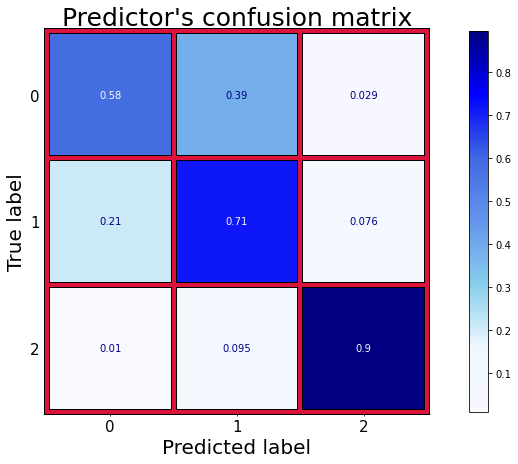

In [ ]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1, 1, figsize = (15, 7))

disp = metrics.ConfusionMatrixDisplay(cm, display_labels=label_names)
disp.plot(ax = ax, cmap = cmap)
ax.set_ylabel('True label', fontsize = 20)
ax.set_xlabel('Predicted label', fontsize = 20)
ax.set_xticklabels(labels =label_names, rotation = 0, fontsize = 15)
ax.set_yticklabels(labels =label_names, fontsize = 15)
ax.set_title('Predictor\'s confusion matrix', fontsize = 25)

x, y, w, h = 0, 0, 1, 1



for i in range(3):
    ax.add_patch(Rectangle((x - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))
    ax.add_patch(Rectangle((x + 1 - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))
    ax.add_patch(Rectangle((x + 2 - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))

for i in range(3):
    ax.add_patch(Rectangle((x - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))
    ax.add_patch(Rectangle((x + 1 - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))
    ax.add_patch(Rectangle((x + 2 - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [ ]:
print(classification_report(y_true, final_predictions, target_names = label_names))

              precision    recall  f1-score   support

           0       0.34      0.58      0.43       790
           1       0.16      0.71      0.27      1580
           2       1.00      0.90      0.94     57363

    accuracy                           0.89     59733
   macro avg       0.50      0.73      0.55     59733
weighted avg       0.97      0.89      0.92     59733



## XGBoost

In [ ]:
regressor = xgb.XGBClassifier(
    n_estimators=100,
    reg_lambda=5,
    gamma=0,
    max_depth=20,
    min_child_weight = 5,
)

In [ ]:
weights_df = pd.DataFrame(final_df_train.iloc[:, 0].astype(str).values, columns = ['labels'])
weights_df['weights'] = weights_df['labels'].map(weights_dict) 

In [ ]:
regressor.fit(np.array(final_df_train.iloc[:, 1:]), np.array(final_df_train.iloc[:,0].astype(str)), sample_weight = weights_df['weights'].values)

/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=20, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=5, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
y_pred = regressor.predict(final_df_test.iloc[:,1:])

In [ ]:
y_true = final_df_test.iloc[:,0].astype(str).values

In [ ]:
y_diff = y_true.astype(int) - y_pred.astype(int)

In [ ]:
print('The accuracy of the model is:', len(y_diff[y_diff == 0])/len(y_diff))

The accuracy of the model is: 0.9647598479902232


In [ ]:
train_err = 1 - regressor.score(final_df_train.iloc[:,1:], final_df_train.iloc[:,0].astype(str), sample_weight = weights_df['weights'].values)
print("Training error = %1.3f" % train_err)
test_err = 1 - regressor.score(final_df_test.iloc[:,1:], final_df_test.iloc[:,0].astype(str), sample_weight = final_df_test.iloc[:,0].astype(str).map(weights_dict).values)
print("Test error = %1.3f" % test_err)

Training error = 0.000
Test error = 0.415


In [ ]:
pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns = final_df_train.iloc[:, 1:].columns).T.sort_values(by = 0, ascending = False)

,0
behind_below,0.255528
prone_below,0.183470
standing_remaining,0.125545
position,0.086830
Behind,0.044889
standing_below,0.039423
back_from_median,0.030072
all_mistakes_prone,0.024439
all_mistakes_standing,0.021431
format,0.020523


In [ ]:

cm = metrics.confusion_matrix(y_true, y_pred, normalize = 'true')
label_names=['0' , '1', '2']

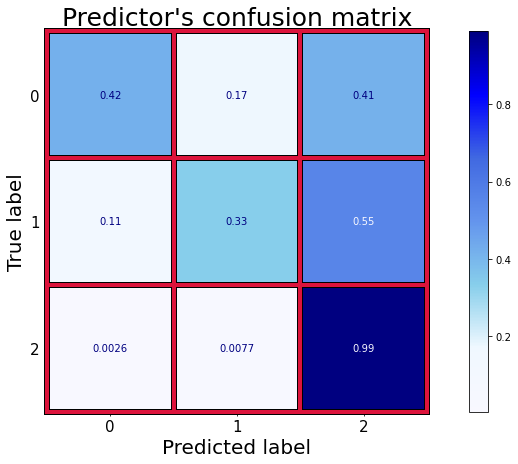

In [ ]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1, 1, figsize = (15, 7))

disp = metrics.ConfusionMatrixDisplay(cm, display_labels=label_names)
disp.plot(ax = ax, cmap = cmap)
ax.set_ylabel('True label', fontsize = 20)
ax.set_xlabel('Predicted label', fontsize = 20)
ax.set_xticklabels(labels =label_names, rotation = 0, fontsize = 15)
ax.set_yticklabels(labels =label_names, fontsize = 15)
ax.set_title('Predictor\'s confusion matrix', fontsize = 25)

x, y, w, h = 0, 0, 1, 1



for i in range(3):
    ax.add_patch(Rectangle((x - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))
    ax.add_patch(Rectangle((x + 1 - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))
    ax.add_patch(Rectangle((x + 2 - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))

for i in range(3):
    ax.add_patch(Rectangle((x - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))
    ax.add_patch(Rectangle((x + 1 - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))
    ax.add_patch(Rectangle((x + 2 - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

## Results discussion

From the aboce confusion matrix we can notice significant differences in performances with respect to our Random Forest Classifier.
For example we see, and this can also be witnessed from the training and test error, a certain amount of overfitting with the model clasfiying the outside the podiums positions very well (probably due to their prevalence in the dataset) but not so well the top positions.

<br/>

The purpose of the grid search though will be that of finding the best parameters for our model, in relatin to the process of finding the lowest possible validation error.

In [14]:
import itertools
max_dephts = [5, 10, 15]
learning_rates = [0.001, 0.1, 0.2, 0.3]
min_child_weights = [5, 10, 15]
reg_lambdas = [0, 0.001, 0.0001, 0.1]

all_models = list(itertools.product(max_dephts, learning_rates, min_child_weights, reg_lambdas))

In [15]:
import itertools
list_models = list(map(lambda x: {'depth':x[0], 'rate':x[1], 'weight': x[2], 'lambdas': x[3]},\
     itertools.product(max_dephts, learning_rates, min_child_weights, reg_lambdas)))

In [18]:
xgboost_results = pd.read_csv('../data/xgb_results.csv')
xgboost_results

,Unnamed: 0,depth,rate,weight,lambdas,model,test_error,training_error
0,0,NaN,NaN,NaN,NaN,0.0,0.236917,0.195870
1,1,NaN,NaN,NaN,NaN,1.0,0.236917,0.195870
2,2,NaN,NaN,NaN,NaN,2.0,0.236917,0.195870
3,3,NaN,NaN,NaN,NaN,3.0,0.236956,0.195873
4,4,NaN,NaN,NaN,NaN,4.0,0.236917,0.195870
...,...,...,...,...,...,...,...,...
110,110,NaN,NaN,NaN,NaN,110.0,0.365551,0.000220
111,111,NaN,NaN,NaN,NaN,111.0,0.365721,0.000242
112,112,NaN,NaN,NaN,NaN,112.0,0.352049,0.000753
113,113,NaN,NaN,NaN,NaN,113.0,0.357083,0.000703


In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
j = 115 

for model in list_models[115:]:
    regressor = xgb.XGBClassifier(
        n_estimators=100,
        reg_lambda=model['lambdas'],
        gamma=0,
        max_depth=model['depth'],
        min_child_weight = model['weight'],
        learning_rate = model['rate']
    )

    weights_df = pd.DataFrame(final_df_train_valid.iloc[:, 0].astype(str).values, columns = ['labels'])
    weights_df['weights'] = weights_df['labels'].map(weights_dict) 

    regressor.fit(np.array(final_df_train_valid.iloc[:, 1:]), np.array(final_df_train_valid.iloc[:,0].astype(str)),\
         sample_weight = weights_df['weights'].values)


    train_err = 1 - regressor.score(final_df_train_valid.iloc[:,1:], final_df_train_valid.iloc[:,0].astype(str),\
            sample_weight = weights_df['weights'].values)

    test_err = 1 - regressor.score(final_df_validation.iloc[:,1:], final_df_validation.iloc[:,0].astype(str),\
            sample_weight = final_df_validation.iloc[:,0].astype(str).map(weights_dict).values)

    
    xgboost_results = xgboost_results.append({'training_error': train_err, 'test_error': test_err, 'model': j},\
         ignore_index = True)

    print(f'{(j + 1) / len(all_models) * 100:.2f} %') # printing progress 
    j += 1

    xgboost_results.to_csv('../data/xgb_results.csv')

[08:43:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
80.56 %
[08:46:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
81.25 %
[08:49:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed 

In [24]:
pd.DataFrame(all_models, columns=['depth', 'rate', 'weight', 'lambdas'])

,depth,rate,weight,lambdas
0,5,0.001,5,0.0000
1,5,0.001,5,0.0010
2,5,0.001,5,0.0001
3,5,0.001,5,0.1000
4,5,0.001,10,0.0000
...,...,...,...,...
139,15,0.300,10,0.1000
140,15,0.300,15,0.0000
141,15,0.300,15,0.0010
142,15,0.300,15,0.0001


In [16]:
df_xgb_results = pd.read_csv('../data/xgb_results.csv')
df_xgb_results.sort_values(by = 'test_error', ascending=True).head(10)
df_xgb_results.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'depth', 'rate', 'weight', 'lambdas'], inplace = True)
df_xgb_results['model'] = df_xgb_results['model'].astype(int)

final_df = pd.merge(df_xgb_results, pd.DataFrame(all_models, columns=['depth', 'rate', 'weight', 'lambdas']), left_on = 'model', right_index = True).sort_values(by = 'test_error', ascending=True)

final_df.head(20)

,model,test_error,training_error,depth,rate,weight,lambdas
8,8,0.234950,0.195889,5,0.001,15,0.0000
10,10,0.234950,0.195889,5,0.001,15,0.0001
9,9,0.234950,0.195889,5,0.001,15,0.0010
11,11,0.234989,0.195892,5,0.001,15,0.1000
6,6,0.236917,0.195870,5,0.001,10,0.0001
0,0,0.236917,0.195870,5,0.001,5,0.0000
4,4,0.236917,0.195870,5,0.001,10,0.0000
2,2,0.236917,0.195870,5,0.001,5,0.0001
1,1,0.236917,0.195870,5,0.001,5,0.0010
5,5,0.236917,0.195870,5,0.001,10,0.0010


In [18]:
list_models[8]

{'depth': 5, 'rate': 0.001, 'weight': 15, 'lambdas': 0}

In [41]:
classifier = xgb.XGBClassifier(
    n_estimators=100,
    reg_lambda=list_models[8]['lambdas'],
    gamma = 0,
    max_depth=list_models[8]['depth'],
    min_child_weight = list_models[8]['weight'],
    learning_rate = list_models[8]['rate']
)

In [42]:
weights_df = pd.DataFrame(final_df_train.iloc[:, 0].astype(str).values, columns = ['labels'])
weights_df['weights'] = weights_df['labels'].map(weights_dict) 

In [43]:
classifier.fit(np.array(final_df_train.iloc[:, 1:]), np.array(final_df_train.iloc[:,0].astype(str)), sample_weight = weights_df['weights'].values)

/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:13:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.001, max_delta_step=0,
              max_depth=5, min_child_weight=15, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [44]:

y_pred = classifier.predict(final_df_test.iloc[:,1:])

y_true = final_df_test.iloc[:,0].astype(str).values

y_diff = y_true.astype(int) - y_pred.astype(int)



In [45]:
print('The accuracy of the model is:', len(y_diff[y_diff == 0])/len(y_diff))

The accuracy of the model is: 0.8431018030234544


In [46]:
train_err = 1 - classifier.score(final_df_train.iloc[:,1:], final_df_train.iloc[:,0].astype(str), sample_weight = weights_df['weights'].values)
print("Training error = %1.3f" % train_err)
test_err = 1 - classifier.score(final_df_test.iloc[:,1:], final_df_test.iloc[:,0].astype(str), sample_weight = final_df_test.iloc[:,0].astype(str).map(weights_dict).values)
print("Test error = %1.3f" % test_err)

Training error = 0.213
Test error = 0.270


In [51]:
classifier_results = pd.DataFrame(classifier.feature_importances_.reshape(1, -1), columns = final_df_train.iloc[:, 1:].columns).T.sort_values(by = 0, ascending = False)
classifier_results

,0
behind_below,0.630113
Behind,0.077770
back_from_median,0.057414
standing_below,0.042269
behind_above,0.033233
standing_remaining,0.030596
km_to_go,0.019513
prone_below,0.018108
format,0.014214
gradient_prone,0.012535


In [48]:

cm = metrics.confusion_matrix(y_true, y_pred, normalize = 'true')
label_names=['0' , '1', '2']

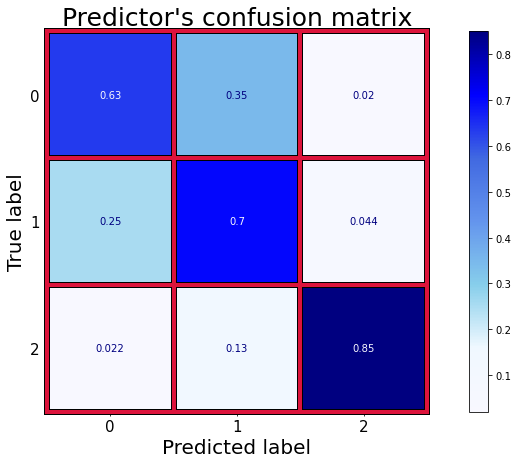

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (15, 7))

disp = metrics.ConfusionMatrixDisplay(cm, display_labels=label_names)
disp.plot(ax = ax, cmap = cmap)
ax.set_ylabel('True label', fontsize = 20)
ax.set_xlabel('Predicted label', fontsize = 20)
ax.set_xticklabels(labels =label_names, rotation = 0, fontsize = 15)
ax.set_yticklabels(labels =label_names, fontsize = 15)
ax.set_title('Predictor\'s confusion matrix', fontsize = 25)

x, y, w, h = 0, 0, 1, 1



for i in range(3):
    ax.add_patch(Rectangle((x - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))
    ax.add_patch(Rectangle((x + 1 - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))
    ax.add_patch(Rectangle((x + 2 - 0.5, i - 0.5), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False, zorder = 2))

for i in range(3):
    ax.add_patch(Rectangle((x - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))
    ax.add_patch(Rectangle((x + 1 - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))
    ax.add_patch(Rectangle((x + 2 - 0.5, i - 0.5), w, h, fill=False, edgecolor='black', lw=6, clip_on=False, zorder = 1))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

<center>

## Discussion of the results
</center>

In the following we will discuss the results of the grid search and the final model for both the Random Forest and the XGBoost's case.
We begin by looking at the confusion matrixes.

<div>

<center> 

<figure>
<img src="../images/random_forest_cm.png" width="500" title = "Random Forest" class="inline-block" display="inline">
    
      
            




<img src="../images/xgb_cm.png" width="500" class="inline-block" display="inline">
<figcaption style = "font-size : 18px">Confusion matrix of the random forest (left) and of the XGBoost algorith (right)</figcaption>
</figure>
<center>
</div>

The thing we should say right away is that we are pleased with the models' performance and that this type of behaviour was not granted given the framework we are working in.
Confronting the 2 confusion matrixes, the XGBoost one performs better in predicting winners, we have similar results for the second and third positions, while the Random Forest is better in predicting the the position after the podium.<br>
We don't mind in reality a little bit less precision in class 2 as the positions after the podium are the over rapresented class in the dataset and prone to feature over-fitting. Summing up, from the confusion matrixes alone we cannot pick a winner.

<br/>

We consider now the test errors, reported in the table below, for the 2 models,

<br/>

<center>

|               | **Random Forest** | **XGBoost** |
|:-------------:|-------------------|:-----------:|
| **test loss** |       0.267       |    0.270    |
</center>

The results are still pretty similar, we rely then to a fery nice thing we have at our disposal when trating with tree-based models: the feature importance.


<center>
<table>
<tr><th>Random Forest feature importance</th><th>XGBoost feature importance</th></tr>
<tr><td>


|  | **Random Forest** |
|-------------------|:-----------:|
|behind_below |	0.190856|
|position |	0.126947|
|standing_below	| 0.126026|
|prone_below |	0.123482|
|Behind	| 0.102859|
|back_from_median | 0.100237|
|prone_above|0.025772|
|km_to_go|0.024428|

</td><td>


|  | **XGBoost** |
|-------------------|:-----------:|
|behind_below|	0.630113|
|Behind|	0.077770|
|back_from_median|	0.057414|
|standing_below	|0.042269|
|behind_above	|0.033233|
|standing_remaining|	0.030596|
|km_to_go	|0.019513|
|prone_below|	0.018108|

</td></tr> </table>

</center>


Here is where we draw the line and we choose the random forest as our winner.
We see infact something we do not particularly like in the XGBoost feature importance: the fact that the feature "behind_below" is so much more important than the other features, this way our model is a little bit too dependent on a single try and we would like to avoid that. Furthermore "behind_below" that is a weighted measure of how distant are opposing biathletes behind the athlete inspected, is not a feature that we expect being that much overwelmingly important, we would have been more confortable with the "Behind" entry along with "position" (that does not even break the top 8!) and "back_from_median" would have been a little more important.